___
# COMP90049 Assignment 3: Toxicity Classification 
___
#### Question:  How does data balancing techniques in toxicity classification affect performance and fairness?
___

#### Notebook 3: Embedded Dataset with Resampling

### 1: Import Data

In [1]:
##############################################################################

import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
from matplotlib import pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import textblob
import os
from collections import Counter
from imblearn.over_sampling import SMOTE

##############################################################################

# Tests
tst_data_class = False

# Dataset objects
# Stores id, comments, and toxicity (if labelled)
class nlp_dataset:
    
    # dataset constructor
    # @pathname: file to be read
    # @unlablled: type of dataset
    def __init__(self, pathname, raw=False, unlabelled=False, resample=False,
                 scaled=False):
        
        self.full = pd.read_csv(pathname)
        self.name = os.path.basename(os.path.normpath(pathname))
        self.size = len(self.full)
        self.groups = self.full[['Asian', 'Bisexual', 'Black', 'Buddhist', 
                                 'Christian','Female', 'Heterosexual','Hindu',
                                 'Homosexual gay or lesbian',
                                 'Intellectual or learning disability',
                                 'Jewish','Latino','Male','Muslim',
                                 'Other disability','Other gender',
                                 'Other race or ethnicity','Other religion',
                                 'Other sexual orientation',
                                 'Physical disability',
                                 'Psychiatric or mental illness',
                                 'Transgender','White']]
        self.ids = self.full['ID']
        self.raw = raw
        
        if (raw):
            self.toxicity = self.full['Toxicity']
            self.raw_comments = self.full['Comment']
            self.comments = self.process_text(self.full['Comment'])
        elif (unlabelled):
            # MIGHT CHANGE BACK
            self.comments = self.full[:,1:]
            self.toxicity = None    
        else:
            # MIGHT CHANGE BACK
            self.comments = self.full.iloc[:,26:]
            self.toxicity = self.full['Toxicity']
        
        # Normalise data
        if (scaled):
            scaler = MinMaxScaler()
            self.comments = scaler.fit_transform(self.comments)
        if (resample):
            self.resample()
        
        # Hard coded
        self.classes = self.toxicity.unique()
        # Frequencies
        self.class_freqs = self.toxicity.value_counts()
        
        # Test allocation
        if (tst_data_class): 
            display(self.ids.head(5))
            display(self.comments.head(5))
            display(self.toxicity.head(5))
            display(self.class_freqs)
            display(sum(self.class_freqs))
            
        return

    # SMOTE resampling
    def resample(self):
        
        print('Original Data Shape:', Counter(self.toxicity))
        sm = SMOTE(random_state=42)
        X_res, y_res = sm.fit_resample(self.comments, self.toxicity)
        print('Resampled Data Shape:', Counter(y_res))
        self.toxicity = y_res
        self.comments = X_res
        print('Resampled Data Shape:', Counter(self.toxicity))
        
    
    # Data and sentiment analysis
    def data_info(self):
        
        # Class distribution
        fig, ax = plt.subplots()
        ax.bar(self.classes, height=self.class_freqs, edgecolor='black', 
                color=['green','red'], alpha=0.3)
        ax.set_xlabel("Classes")
        ax.set_ylabel("Frequency")
        ax.set_title("Toxicity Class Distribution")
        plt.xticks(self.classes)
        plt.show()
        
        # Comment Lengths
        fig, ax00 = plt.subplots()
        ax00.hist(self.comment0_lens, color='blue', edgecolor='black',
                  alpha=0.3)
        ax00.set_xlabel('Number of Words')
        ax00.set_ylabel('Non-Toxic Frequency')
        ax00.set_title('Comment Length')
        
        ax01 = ax00.twinx()
        ax01.hist(self.comment1_lens, color='red', edgecolor='black', 
                 label='Toxic', alpha=0.3)
        ax01.set_ylabel('Non-Toxic Frequency')
        plt.legend()
        plt.show()        
        
        # Generate stacked_distributions of each sensitive group
        self.cross_table = self.freq_distributions(self.groups, self.toxicity)
        display(cross_table)
        
        
        
    # Generates stacked frequency distributions
    # @df: dataframe of comments
    # @toxicity: series of toxicity
    def freq_distributions(self, df, toxicity):

        # Figure representations
        num_rows = 2
        num_cols = 2
        subplots = num_rows*num_cols
        fig_size = (15, 8)
        
        all_crosstabs = []

        # Generate figures and plot
        #TODO: Return table from cross tab!
        for num, feature in enumerate(df):

            subposition = num % subplots

            # New Figure 
            if (subposition == 0):

                # Display old figure
                plt.show()

                # Last features 
                if ((len(df.columns) - num) < 3):
                    num_rows = 1
                    fig_size = (10,1)

                # Plots and display
                fig, axes = plt.subplots(num_rows, num_cols, figsize=fig_size)
                fig.tight_layout(h_pad=10, w_pad=5)
                axes = axes.ravel()

            if (feature == 'label'):
                break

            # Generate plot
            crosstab = pd.crosstab(df[feature], self.toxicity)
            sub_title = "\"" + feature + "\" group Frequencies"
            crosstab.plot(ax=axes[subposition], kind='bar', stacked=True,
                             figsize=(10,7), title=sub_title, 
                             alpha=0.3, color=['green','red'])
            
            # Accumulate crosstabs
            crosstab = pd.concat([crosstab], keys=[feature], names=['Group'])
            crosstab.index.names=['Group','']
            all_crosstabs.append(crosstab)
        plt.show()
        
        # Generate table
        for i, ct in enumerate(all_crosstabs): 
            if (i == 0):
                cross_table = ct
            else:
                cross_table = pd.concat([cross_table, ct])
        
        # Add percentage information
        #portion = cross_table["0"] + cross_table["1"]
        cross_table['Percentage'] = cross_table[list(cross_table.columns)].sum(axis=1)
        cross_table['Percentage']=cross_table['Percentage'].div(self.size).round(4)
        cross_table = cross_table.style.set_caption("Group/Toxicity Cross Tabulation")
        display(cross_table)
        
        return cross_table
        
        
    
    # Data Analysis
    # @comments: raw comments to analyse
    # @stem: Bool on whether to stem
    # @lemmatize: Bool on whether to lemmatize
    def process_text(self, comments, stem=False, lemmatize=False):
    
        # Initialise
        s = comments.copy()
        # Case folding
        s = s.str.lower()
        # Remove punctuation
        s = [x.translate(str.maketrans('', '', string.punctuation)) for x in s]
        # Remove \n
        s = [x.replace("\n", "") for x in s]
        # Tokenise
        s = [nltk.word_tokenize(x) for x in s]
        
        # Comment Lengths
        self.comment_lengths = [len(x) for x in s]
        self.comment0_lens = []
        self.comment1_lens = []
        for comment, toxicity in zip(self.comment_lengths, self.toxicity):
            if (toxicity):
                self.comment1_lens.append(comment)
            else:
                self.comment0_lens.append(comment)
        
        # Stopword removal
        stop_words = set(stopwords.words('english'))
        for i, comment in enumerate(s):
            # Change to series?
            s[i] = [w for w in comment if not w in stop_words]

        # Stemming
        if (stem):
            # Should you use stemming and lemmatization or just one?
            porterStemmer = PorterStemmer()
            for i, comment in enumerate(s):
                s[i] = [porterStemmer.stem(w) for w in comment]
        elif (lemmatize):
            # Lemmatisation
            lemmatizer = WordNetLemmatizer()
            for i, comment in enumerate(s):
                s[i] = [lemmatizer.lemmatize(w) for w in comment]

        return pd.Series(s)
    
    # Publishes sentiment information about dataset
    def sentiment_analysis(self):

        if (self.raw):
            c0, c1, p0, p1, s0, s1 = [], [], [], [], [], []

            for x, y in zip(self.raw_comments, self.toxicity):
                tb = TextBlob(x)
                sment = tb.sentiment

                if (y == 0):
                    c0.append(tb)
                    p0.append(sment.polarity)
                    s0.append(sment.subjectivity)
                else:
                    c1.append(tb)
                    p1.append(sment.polarity)
                    s1.append(sment.subjectivity)

            # Class lengths
            len0 = len(c0)
            len1 = len(c1)
            
            # Publish Sentiments
            print("Sentiment Results for " + self.name + " dataset:")
            print("\tAverage polarity:", round(((sum(p0) + sum(p1))/(len0+len1)), 4))
            print("\t\tClass 0 average polarity:", round(sum(p0)/len0, 4))
            print("\t\tClass 1 average polarity:", round(sum(p1)/len1, 4))
            print("\tAverage subjectivity:", round(((sum(s0) + sum(s1))/(len0+len1)), 4))
            print("\t\tClass 0 average subjectivity:", round(sum(s0)/len0, 4))
            print("\t\tClass 1 average subjectivity:", round(sum(s1)/len1, 4))
            
            # Visualise Polarity 
            n_bins = 20
            fig, ax = plt.subplots()
            ax.hist(p0, bins=n_bins, color='blue', edgecolor='black', 
                    label='Non-Toxic', alpha=0.3)
            ax.set_title ('Polarity')
            ax.set_xlabel('Polarity')
            ax.set_ylabel('Non-Toxic Frequency')
            
            ax01 = ax.twinx()
            ax01.hist(p1, bins=n_bins, color='red', edgecolor='black', 
                    label='Toxic', alpha=0.3)
            ax01.set_ylabel('Toxic Frequency')
            plt.legend()
            plt.show()
            
            # Visualise Subjectivity
            fig1, ax1 = plt.subplots()
            ax1.hist(s0, bins=n_bins, color='blue', edgecolor='black', 
                    label='Non-Toxic', alpha=0.3)
            ax1.set_title ('Subjectivity')
            ax1.set_xlabel('Subjectivity')
            ax1.set_ylabel('Non-Toxic Frequency')
            
            ax11 = ax1.twinx()
            ax11.hist(s1, bins=n_bins, color='red', edgecolor='black', 
                    label='Toxic', alpha=0.3)
            ax11.set_ylabel('Toxic Frequency')
            plt.legend()
            plt.show()
            
        return
    
##############################################################################


#### To process, import based on iteration:

In [2]:
##############################################################################

## Iteration 2: SMOTE Resampling
emb_train = nlp_dataset(r'dataset/train_embedding.csv', resample=True)
emb_dev = nlp_dataset(r'dataset/dev_embedding.csv')
emb_test = nlp_dataset(r'dataset/test_embedding.csv')

##############################################################################

Original Data Shape: Counter({0: 117514, 1: 22486})
Resampled Data Shape: Counter({0: 117514, 1: 117514})
Resampled Data Shape: Counter({0: 117514, 1: 117514})


___
### 2: Modelling

In [3]:
##############################################################################

# Wrapper for models and their information
class nlp_model():
    
    # Initalises wrapper
    # @model: pre-initialised model
    # @train_data: dataframe to fit
    # @name: String
    def __init__(self, model, train_data, name, d_type, 
                 neural_net=False, epochs=0, b_size=0, val_data=None,
                 callbacks=None):
        
        # Store
        self.model = model
        self.train_data = train_data
        self.name = name
        self.d_type = d_type
        self.descriptor = name + '_' + d_type
        self.neural_net = neural_net
    
        # Train
        if (not neural_net):
            self.model.fit(train_data.comments, train_data.toxicity)
        else:
            # Compile 
            self.history = self.model.fit(train_data.comments, 
                           train_data.toxicity,
                           epochs=epochs, batch_size=b_size, 
                           validation_data=(val_data.comments, val_data.toxicity),
                           callbacks=[callbacks])
                           
        return
    
    # Predictions based on model type
    # @test_data: series to make predictions on
    # @threshold: [0-1] probability adjustment
    def predict(self, test_data, threshold=None):
        
        if (self.neural_net):
            predictions = self.model.predict(test_data)
            return np.argmax(predictions, axis=1)
            #return self.model.predict_classes(test_data)
        elif (threshold != None):
            return (self.model.predict_proba(test_data)[:,1]>=threshold).astype(int)
        else:
            return self.model.predict(test_data)

##############################################################################

#### Suite of Models:

In [39]:
##############################################################################

## Tfidf KNN Model

# Dictionaries
from sklearn.neighbors import KNeighborsClassifier as KNN

#emb_knn1 = nlp_model(KNN(n_neighbors=1), emb_train, 'KNN 1', 'Tfidf')
#emb_knn3 = nlp_model(KNN(n_neighbors=3), emb_train, 'KNN 3', 'Tfidf')
emb_knn5 = nlp_model(KNN(n_neighbors=5), emb_train, 'KNN 5', 'Tfidf')
#emb_knn10 = nlp_model(KNN(n_neighbors=10), emb_train, 'KNN 10', 'Tfidf')

##############################################################################

In [35]:
##############################################################################

## Naive Bayes Model

# Dictionaries
from sklearn.naive_bayes import BernoulliNB

# Instances
emb_bnb = nlp_model(BernoulliNB(), emb_train, 'Bernoulli_Naive_Bayes', 
                    'Embedded')

##############################################################################


In [ ]:
##############################################################################

## Weighted Naive Bayes

from sklearn.naive_bayes import ComplementNB

emb_cnb = nlp_model(ComplementNB(), sc_emb_train, 'Complement_Naive_Bayes', 
                   'Embedded')

##############################################################################

In [5]:
##############################################################################

## Logistic Regression Model 

# Dictionaries
from sklearn.linear_model import LogisticRegression

# Instances
emb_lrm = nlp_model(LogisticRegression(solver='newton-cg'), emb_train, 
                    'Logistic_Regression','Embedded_SMOTE')

##############################################################################

In [4]:
##############################################################################

## Simple Multilayer Perceptron

from sklearn.neural_network import MLPClassifier

# Parameters
layers = (200, 150, 5)
iters = 200
activ = 'relu'
sol = 'lbfgs'
verbose = 10
alpha = 0.0001
ran = 1
lr = 'constant'

mlp = MLPClassifier(hidden_layer_sizes=layers, max_iter=iters,
                    early_stopping=False, warm_start=True,
                   activation=activ, solver=sol, verbose=verbose,
                   random_state=ran, learning_rate=lr, alpha=alpha)

emb_mlp = nlp_model(mlp, emb_train, 'Multilayer_Perceptron', 'Embedded_SMOTE')

##############################################################################

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       107911     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.80841D-01    |proj g|=  2.02140D-01

At iterate    1    f=  6.95573D-01    |proj g|=  3.35665D-02

At iterate    2    f=  6.92972D-01    |proj g|=  7.57715D-03

At iterate    3    f=  6.92146D-01    |proj g|=  6.02829D-03

At iterate    4    f=  6.91158D-01    |proj g|=  1.55293D-02

At iterate    5    f=  6.87161D-01    |proj g|=  3.78329D-02

At iterate    6    f=  6.79241D-01    |proj g|=  7.96795D-02

At iterate    7    f=  6.73558D-01    |proj g|=  1.08541D-01

At iterate    8    f=  6.63283D-01    |proj g|=  1.46646D-01

At iterate    9    f=  6.38573D-01    |proj g|=  1.36711D-01

At iterate   10    f=  6.17546D-01    |proj g|=  5.52933D-02

At iterate   11    f=  6.12556D-01    |proj g|=  5.36481D-02

At iterate   12    f=  6.07020D-01    |proj g|=  4.12190D-02

At iterate   13    f=  5.9


At iterate  130    f=  3.98768D-01    |proj g|=  2.91466D-02

At iterate  131    f=  3.98524D-01    |proj g|=  2.71022D-02

At iterate  132    f=  3.98291D-01    |proj g|=  1.04578D-01

At iterate  133    f=  3.98020D-01    |proj g|=  3.14046D-02

At iterate  134    f=  3.97668D-01    |proj g|=  7.66819D-02

At iterate  135    f=  3.97530D-01    |proj g|=  7.85356D-02

At iterate  136    f=  3.96614D-01    |proj g|=  2.31414D-01

At iterate  137    f=  3.95582D-01    |proj g|=  8.37272D-02

At iterate  138    f=  3.95258D-01    |proj g|=  6.03666D-02

At iterate  139    f=  3.94876D-01    |proj g|=  2.03931D-02

At iterate  140    f=  3.94509D-01    |proj g|=  2.85952D-02

At iterate  141    f=  3.94114D-01    |proj g|=  4.28839D-02

At iterate  142    f=  3.93588D-01    |proj g|=  1.31617D-01

At iterate  143    f=  3.92936D-01    |proj g|=  7.31966D-02

At iterate  144    f=  3.91250D-01    |proj g|=  6.40238D-02

At iterate  145    f=  3.89654D-01    |proj g|=  4.75104D-02

At iter

/Users/Mystic/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [24]:
##############################################################################

## MLP Optimisation

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

base_mlp = MLPClassifier(max_iter=300)

param_grid = {
    'hidden_layer_sizes': [(200, 150), (200, 150, 5), (300, 150)],
    'activation': ['relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant'],
    'early_stopping': [True]
}
opt_mlp = GridSearchCV(base_mlp, param_grid, n_jobs=-1, cv=3, verbose=10)
opt_mlp.fit(emb_dev.comments, emb_dev.toxicity)

# Optimal parameters:
print('Best parameters found:\n', opt_mlp.best_params_)
#{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 
#'learning_rate': 'constant', 'solver': 'lbfgs'}

##############################################################################

Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\tjaho\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\tjaho\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\tjaho\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\tjaho\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\tjaho\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\tjaho\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature name

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (200, 150), 'learning_rate': 'constant', 'solver': 'adam'}


C:\Users\tjaho\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


___
### 3: Evaluation

In [6]:
##############################################################################

# Dictionaries
from sklearn.metrics import (classification_report, accuracy_score, 
   confusion_matrix, PrecisionRecallDisplay, precision_recall_curve,
   RocCurveDisplay as ROC, ConfusionMatrixDisplay, cohen_kappa_score,
   precision_score, recall_score, mean_squared_error as MSE)
import numpy as np
import matplotlib.pyplot as plt
from fairlearn.metrics import (MetricFrame, selection_rate, 
    equalized_odds_difference,
    demographic_parity_ratio, demographic_parity_difference,
    count, false_negative_rate, false_positive_rate)
    

##############################################################################

# Test Switches
test_fairness = True

# Wraps peformance and fairness analytics
class nlp_evaluation():
    
    # Initialises wrapper
    # @model: sklearn Classifier
    # @test_data: data to be evaluated
    # @threshold: [0-1] probability adjustment
    def __init__(self, model, test_data, threshold=None):
    
        self.model = model
        self.test_data = test_data
        train_data = model.train_data
        
        # Training Results
        self.t_predictions = model.predict(train_data.comments, threshold)
        self.t_accuracy = accuracy_score(train_data.toxicity, self.t_predictions)
        self.t_kappa = cohen_kappa_score(train_data.toxicity, self.t_predictions)
        self.t_precision, self.t_recall, self.t_thresholds = precision_recall_curve(
            train_data.toxicity, self.t_predictions)
        self.t_report = classification_report(train_data.toxicity, self.t_predictions)
        self.t_con_matrix = confusion_matrix(train_data.toxicity, self.t_predictions)
        # Curves
        self.t_pr_display = PrecisionRecallDisplay(precision=self.t_precision,
                                                recall=self.t_recall)
        self.t_cm_display = ConfusionMatrixDisplay(confusion_matrix=self.t_con_matrix)
        
        # Dev Results:
        self.predictions = model.predict(test_data.comments, threshold)
        self.accuracy = accuracy_score(test_data.toxicity, self.predictions)
        self.kappa = cohen_kappa_score(test_data.toxicity, self.predictions)
        self.precision, self.recall, self.thresholds = precision_recall_curve(
            test_data.toxicity, self.predictions)
        self.report = classification_report(test_data.toxicity, self.predictions)
        self.con_matrix = confusion_matrix(test_data.toxicity, self.predictions)
        
        # Curves
        self.pr_display = PrecisionRecallDisplay(precision=self.precision,
                                                recall=self.recall)
        self.cm_display = ConfusionMatrixDisplay(confusion_matrix=self.con_matrix)
        
        
        return
    
    # Performance analysis - focus on minority class
    def publish(self, message=None):
        
        # Display evaluation metrics
        print("-------------------------------------------------------------")
        print("\nEvaluation Report for", self.model.descriptor)
        
        # Extra message
        if (isinstance(message, str)):
            print("\n" + message)
        
        print("\n-------------------------------------------------------------")
        # Publish results 
        # Train
        print("\nTrain Set Scores")
        print("------------------\n")
        print("Metrics:")
        print("\tTrain Accuracy:", round(self.t_accuracy,4))
        # Kappa's Coefficient
        # Number between -1 and 1. Max value means complete agreement.
        # Zero or lower means chance agreement.
        print("\tTrain Cohen-Kappa Coefficient:", round(self.kappa, 4))
        print("\tThresholds:", self.thresholds)
        print("\tSSE: ", round(MSE(self.predictions, self.test_data.toxicity)))
        print("\nClassification report:\n", self.report)
        # Confusion Matrix
        self.t_cm_display.plot()
        plt.title('Train CM - ' + self.model.descriptor)
        plt.show()
        print("\n-------------------------------------------------------------")

        print("\nValidation Set Scores")
        print("-----------------------\n")
        print("Metrics:")
        print("\tVal Accuracy:", round(self.accuracy,4))
        print("\tVal Cohen-Kappa Coefficient:", round(self.kappa, 4))
        print("\tVal Thresholds:", self.thresholds)
        print("\tVal SSE: ", round(MSE(self.predictions, self.test_data.toxicity)))
        print("\nClassification report:\n", self.report)
        # Confusion Matrix
        self.cm_display.plot()
        plt.title('Val CM - ' + self.model.descriptor)
        plt.show()
        
        print("\n-------------------------------------------------------------")
        print("\nFitness Visualisations")
        print("------------------------\n")
        # Precision Recall Curve
        fig, ax = plt.subplots()
        self.pr_display.plot(ax=ax, label='Val')
        self.t_pr_display.plot(ax=ax, label='Train')
        plt.title('PR Curve - ' + self.model.descriptor)
        plt.show()
        
        # ROC Curve
        fig, ax1 = plt.subplots()
        ROC.from_predictions(self.model.train_data.toxicity, 
                             self.t_predictions, name='Train', ax=ax1)
        ROC.from_predictions(self.test_data.toxicity, self.predictions,
                            name='Val', ax=ax1)
        plt.title('ROC Curve - ' + self.model.descriptor)
        plt.show()
            
        return
    
    # Analyses fairness through demographic parity and equalised odds
    def fairness(self):
        
        print("\n-------------------------------------------------------------")
        print("\nFAIRNESS METRICS")
        print("------------------------\n")
        
        # Visualisations of each group
        groups = ['Male', 'Female', 'Transgender', 'Other gender']
        for group in groups:
            self.metric_frame(group)
        
        # Tablurarised Fairness Metrics
        labels = self.test_data.toxicity
        impacts, parities, eq_odds, fprs, fnrs = [], [], [], [], []
        for group, values in self.test_data.groups[groups].iteritems():
            
            d_impact = demographic_parity_ratio(labels,
                                self.predictions,
                                sensitive_features=values)
            d_parity = demographic_parity_difference(labels,
                                self.predictions,
                                sensitive_features=values)
            eq_odd = equalized_odds_difference(labels, self.predictions, 
                            sensitive_features=values)            
            impacts.append(round(d_impact, 4))
            parities.append(round(d_parity, 4))
            eq_odds.append(round(eq_odd, 4))
            
            # Test
            if (test_fairness):
                print("\n", group)
                print("\tDisparate Impact:", round(d_impact,4))
                print("\tDemographic Parity:", round(d_parity, 4))
                print("\tEq odds:", round(eq_odd, 4))
        
        # Generate Table
        d = {'Disparate Impact': impacts, 'Demographic Parity': parities,
            'Equalised Odds': eq_odds}
        self.f_table = pd.DataFrame(data=d)
        self.f_table['Group'] = self.test_data.groups[groups].columns
        self.f_table.set_index('Group', inplace=True)
        self.f_table = self.f_table.style.set_caption(
            "Fairness Metrics for " + self.model.descriptor)
        display(self.f_table)
        
    
    # Visualisations of fairness metrics
    # @group: String of group identifier
    def metric_frame(self, group):
        
        metrics = {
            'Accuracy': accuracy_score,
            'Precision': precision_score,
            'Recall': recall_score,
            'FPR': false_positive_rate,
            'FNR': false_negative_rate,
            'Selection rate': selection_rate}
        
        metric_frame = MetricFrame(metrics=metrics,
                           y_true=self.test_data.toxicity,
                           y_pred=self.predictions,
                           sensitive_features=self.test_data.groups[group])
        metric_frame.by_group.plot.bar(
            subplots=True,
            layout=[3, 3],
            legend=False,
            figsize=[12, 8],
            title=group + ' Fairness Results',
            alpha=0.3
        )
    
    # Sum of Squared errors (Error function for Linear Regression)
    def SSE(y_predict, y_actual):
        return np.sum((y_predict - y_actual)**2)
    
##############################################################################

-------------------------------------------------------------

Evaluation Report for KNN 5_Tfidf

-------------------------------------------------------------

Train Set Scores
------------------

Metrics:
	Train Accuracy: 0.6876
	Train Cohen-Kappa Coefficient: 0.0796
	Thresholds: [0 1]
	SSE:  1

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.22      0.36     12165
           1       0.22      0.96      0.36      2835

    accuracy                           0.36     15000
   macro avg       0.59      0.59      0.36     15000
weighted avg       0.82      0.36      0.36     15000



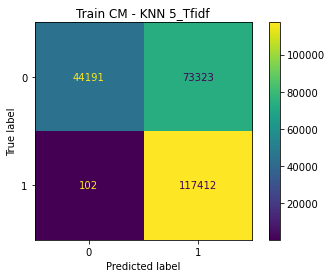


-------------------------------------------------------------

Validation Set Scores
-----------------------

Metrics:
	Val Accuracy: 0.3596
	Val Cohen-Kappa Coefficient: 0.0796
	Val Thresholds: [0 1]
	Val SSE:  1

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.22      0.36     12165
           1       0.22      0.96      0.36      2835

    accuracy                           0.36     15000
   macro avg       0.59      0.59      0.36     15000
weighted avg       0.82      0.36      0.36     15000



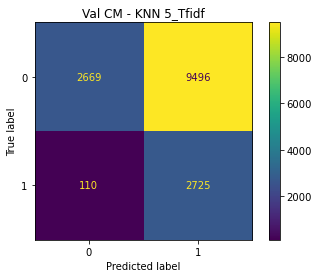


-------------------------------------------------------------

Fitness Visualisations
------------------------



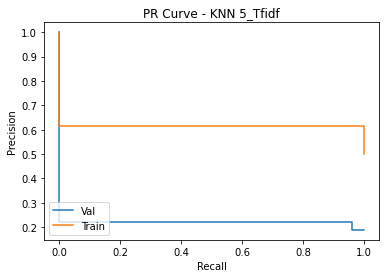

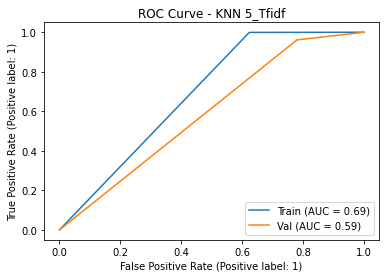

FAIRNESS METRICS


C:\Users\tjaho\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Male
	Disparate Impact: 0.9867
	Demographic Parity: 0.0109
	Eq odds: 0.0073

 Female
	Disparate Impact: 0.9574
	Demographic Parity: 0.0352
	Eq odds: 0.0374

 Transgender
	Disparate Impact: 0.9062
	Demographic Parity: 0.0842
	Eq odds: 0.0953

 Other gender
	Disparate Impact: 0.8147
	Demographic Parity: 0.1853
	Eq odds: 0.9612


,Disparate Impact,Demographic Parity,Equalised Odds
Group,,,
Male,0.986700,0.010900,0.007300
Female,0.957400,0.035200,0.037400
Transgender,0.906200,0.084200,0.095300
Other gender,0.814700,0.185300,0.961200


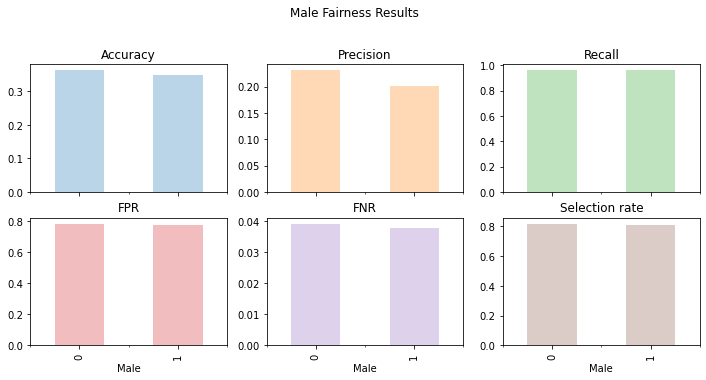

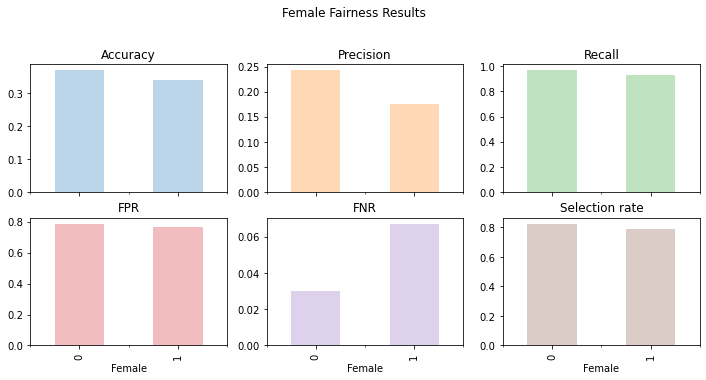

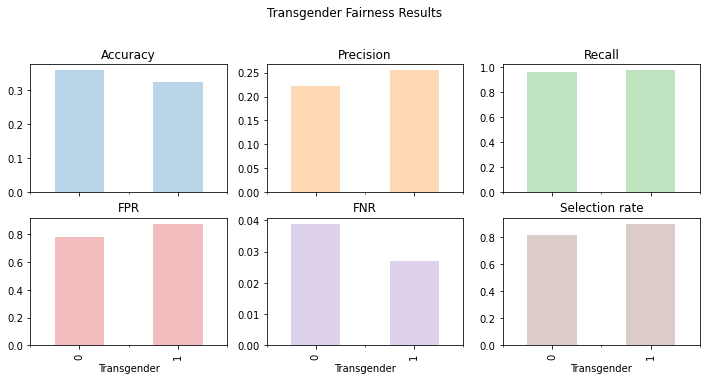

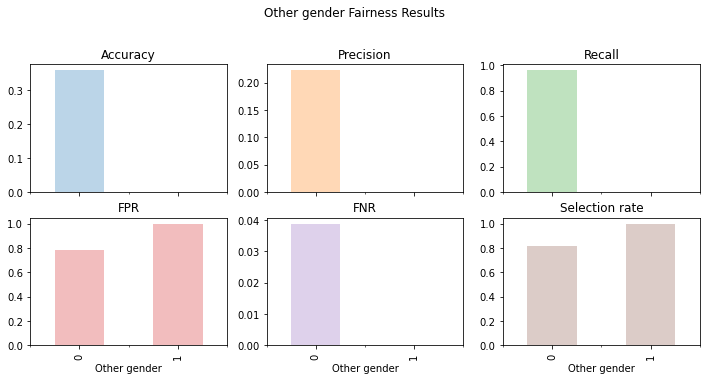

In [41]:
##############################################################################

# Emb KNN evaluation
#emb_knn1_eval = nlp_evaluation(emb_knn1, emb_dev)
#emb_knn3_eval = nlp_evaluation(emb_knn3, emb_dev)
emb_knn5_eval = nlp_evaluation(emb_knn5, emb_dev)
#emb_knn10_eval = nlp_evaluation(emb_knn10, emb_dev)

#emb_knn1_eval.publish()
#emb_knn3_eval.publish()
emb_knn5_eval.publish()
#emb_knn10_eval.publish()

emb_knn5_eval.fairness()


##############################################################################

-------------------------------------------------------------

Evaluation Report for Bernoulli_Naive_Bayes_Embedded

-------------------------------------------------------------

Train Set Scores
------------------

Metrics:
	Train Accuracy: 0.7051
	Train Cohen-Kappa Coefficient: 0.2479
	Thresholds: [0 1]
	SSE:  0

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.67      0.77     12165
           1       0.33      0.68      0.44      2835

    accuracy                           0.67     15000
   macro avg       0.61      0.68      0.60     15000
weighted avg       0.79      0.67      0.71     15000



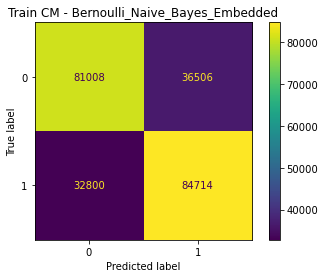


-------------------------------------------------------------

Validation Set Scores
-----------------------

Metrics:
	Val Accuracy: 0.6735
	Val Cohen-Kappa Coefficient: 0.2479
	Val Thresholds: [0 1]
	Val SSE:  0

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.67      0.77     12165
           1       0.33      0.68      0.44      2835

    accuracy                           0.67     15000
   macro avg       0.61      0.68      0.60     15000
weighted avg       0.79      0.67      0.71     15000



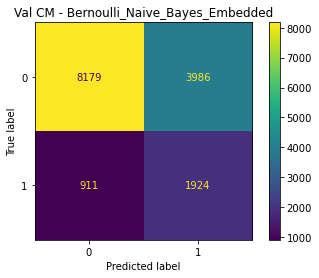


-------------------------------------------------------------

Fitness Visualisations
------------------------



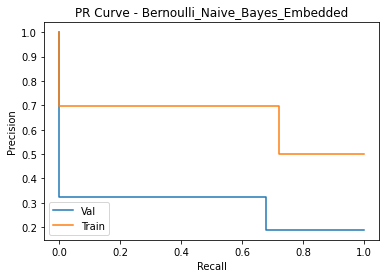

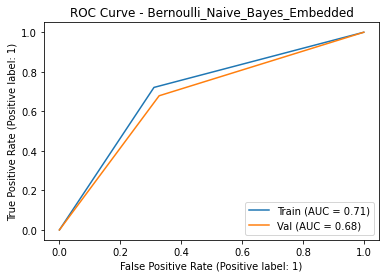

FAIRNESS METRICS


C:\Users\tjaho\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tjaho\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Male
	Disparate Impact: 0.7429
	Demographic Parity: 0.1092
	Eq odds: 0.1288

 Female
	Disparate Impact: 0.5433
	Demographic Parity: 0.2092
	Eq odds: 0.2096

 Transgender
	Disparate Impact: 0.8881
	Demographic Parity: 0.0441
	Eq odds: 0.2495

 Other gender
	Disparate Impact: 0.0
	Demographic Parity: 0.394
	Eq odds: 0.6787


,Disparate Impact,Demographic Parity,Equalised Odds
Group,,,
Male,0.742900,0.109200,0.128800
Female,0.543300,0.209200,0.209600
Transgender,0.888100,0.044100,0.249500
Other gender,0.000000,0.394000,0.678700


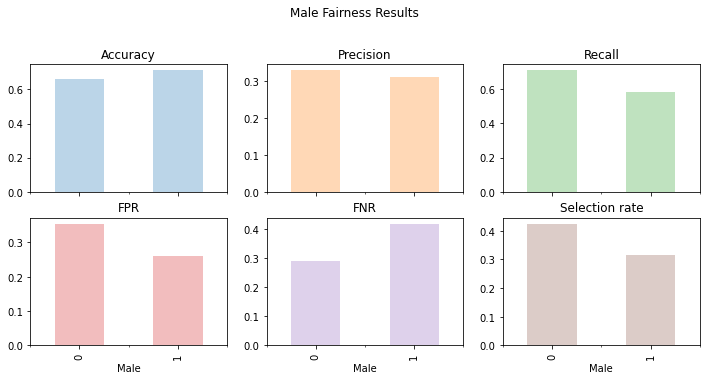

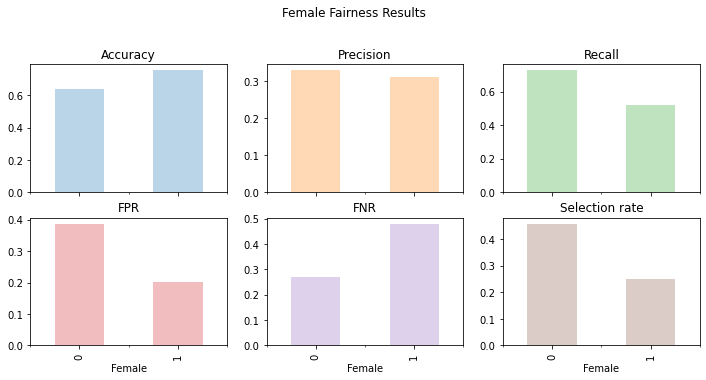

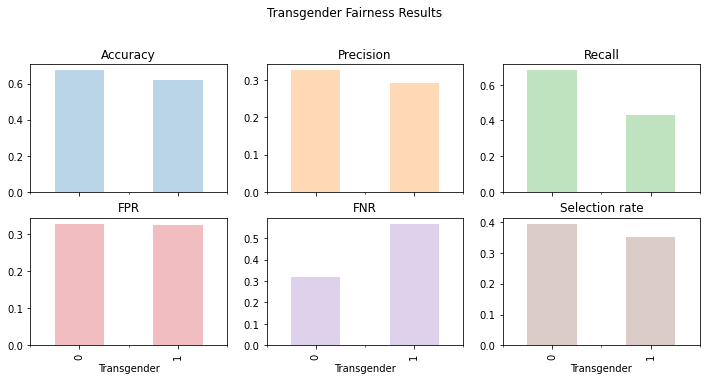

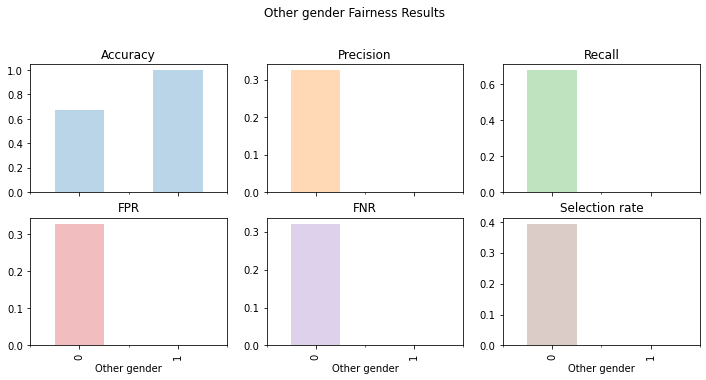

In [37]:
##############################################################################

# Dev NB evaluation
emb_bnb_eval = nlp_evaluation(emb_bnb, emb_dev)
emb_bnb_eval.publish()
emb_bnb_eval.fairness()

##############################################################################

In [ ]:
##############################################################################

# Dev Weighted NB evaluation
emb_cnb_eval = nlp_evaluation(emb_cnb, sc_emb_dev)
emb_cnb_eval.publish()
emb_cnb_eval.fairness()

##############################################################################

-------------------------------------------------------------

Evaluation Report for Logistic_Regression_Embedded_SMOTE

-------------------------------------------------------------

Train Set Scores
------------------

Metrics:
	Train Accuracy: 0.776
	Train Cohen-Kappa Coefficient: 0.344
	Thresholds: [0 1]
	SSE:  0

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.72      0.81     12165
           1       0.39      0.74      0.51      2835

    accuracy                           0.73     15000
   macro avg       0.65      0.73      0.66     15000
weighted avg       0.82      0.73      0.75     15000



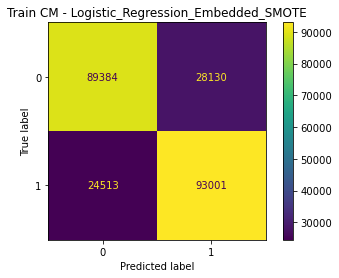


-------------------------------------------------------------

Validation Set Scores
-----------------------

Metrics:
	Val Accuracy: 0.7277
	Val Cohen-Kappa Coefficient: 0.344
	Val Thresholds: [0 1]
	Val SSE:  0

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.72      0.81     12165
           1       0.39      0.74      0.51      2835

    accuracy                           0.73     15000
   macro avg       0.65      0.73      0.66     15000
weighted avg       0.82      0.73      0.75     15000



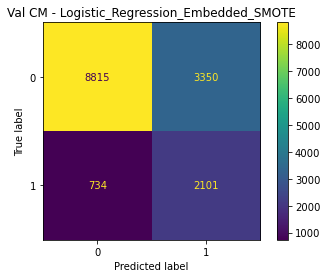


-------------------------------------------------------------

Fitness Visualisations
------------------------



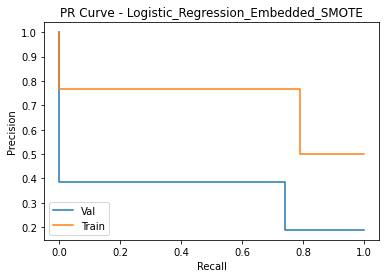

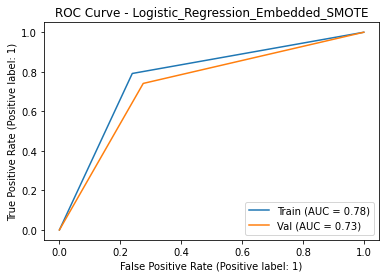


-------------------------------------------------------------

FAIRNESS METRICS
------------------------



/Users/Mystic/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Mystic/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Male
	Disparate Impact: 0.8152
	Demographic Parity: 0.0708
	Eq odds: 0.0684

 Female
	Disparate Impact: 0.6996
	Demographic Parity: 0.1202
	Eq odds: 0.1071

 Transgender
	Disparate Impact: 0.6758
	Demographic Parity: 0.1734
	Eq odds: 0.1848

 Other gender
	Disparate Impact: 0.0
	Demographic Parity: 0.3634
	Eq odds: 0.7411


,Disparate Impact,Demographic Parity,Equalised Odds
Group,,,
Male,0.815200,0.070800,0.068400
Female,0.699600,0.120200,0.107100
Transgender,0.675800,0.173400,0.184800
Other gender,0.000000,0.363400,0.741100


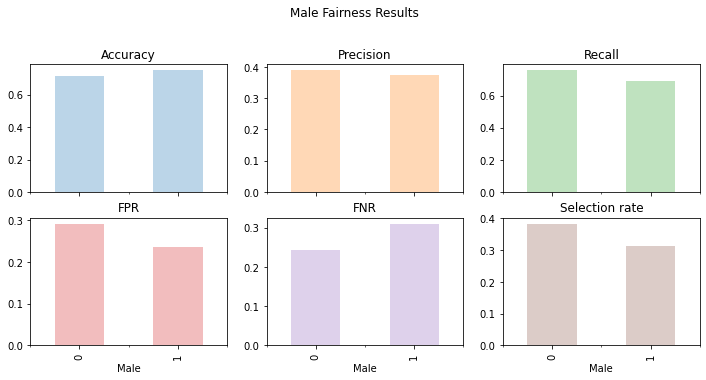

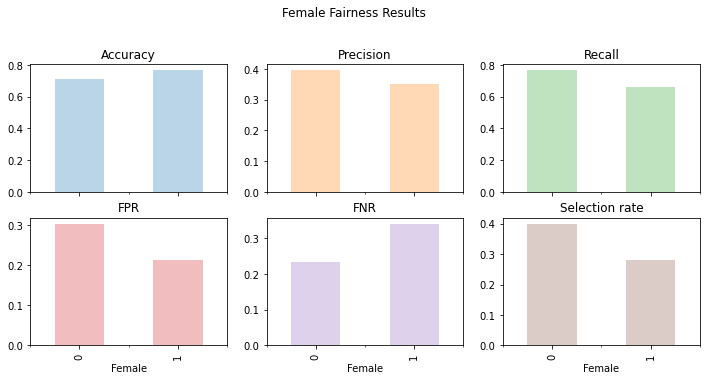

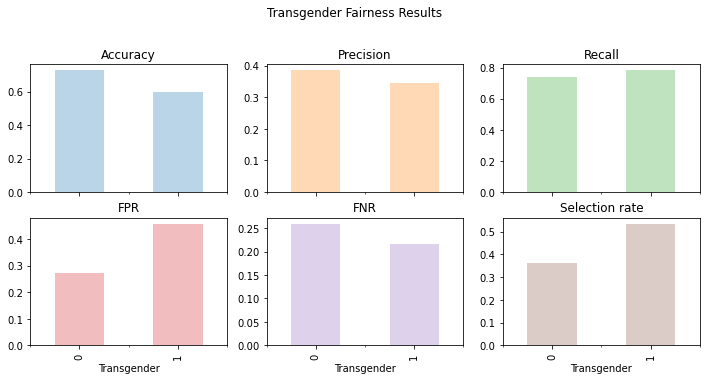

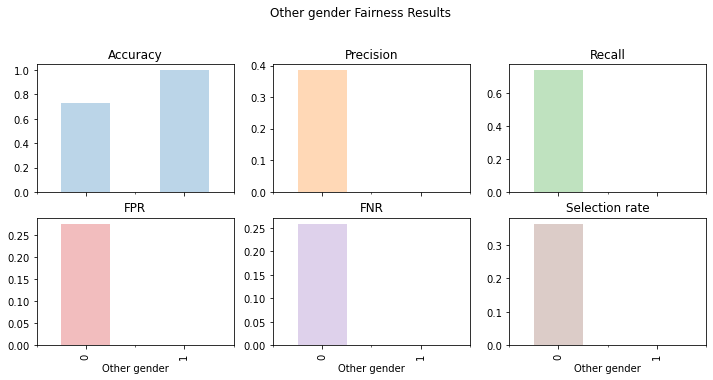

In [7]:
##############################################################################

# Dev lrm evaluation
emb_lrm_eval = nlp_evaluation(emb_lrm, emb_dev)
emb_lrm_eval.publish()
emb_lrm_eval.fairness()

##############################################################################

-------------------------------------------------------------

Evaluation Report for Multilayer_Perceptron_Embedded_SMOTE

-------------------------------------------------------------

Train Set Scores
------------------

Metrics:
	Train Accuracy: 0.839
	Train Cohen-Kappa Coefficient: 0.3409
	Thresholds: [0 1]
	SSE:  0

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.79      0.84     12165
           1       0.41      0.61      0.49      2835

    accuracy                           0.76     15000
   macro avg       0.65      0.70      0.67     15000
weighted avg       0.81      0.76      0.78     15000



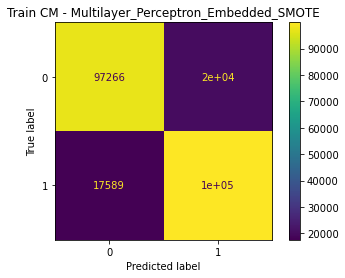


-------------------------------------------------------------

Validation Set Scores
-----------------------

Metrics:
	Val Accuracy: 0.7599
	Val Cohen-Kappa Coefficient: 0.3409
	Val Thresholds: [0 1]
	Val SSE:  0

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.79      0.84     12165
           1       0.41      0.61      0.49      2835

    accuracy                           0.76     15000
   macro avg       0.65      0.70      0.67     15000
weighted avg       0.81      0.76      0.78     15000



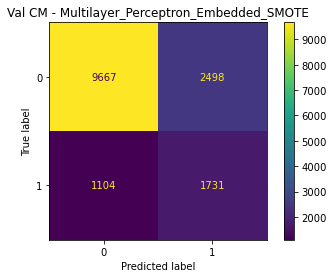


-------------------------------------------------------------

Fitness Visualisations
------------------------



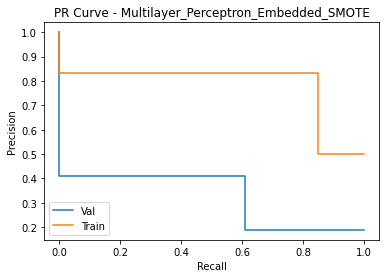

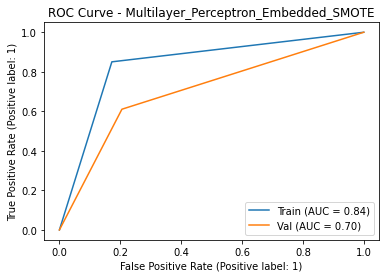


-------------------------------------------------------------

FAIRNESS METRICS
------------------------



/Users/Mystic/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Mystic/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Male
	Disparate Impact: 0.8229
	Demographic Parity: 0.0526
	Eq odds: 0.0695

 Female
	Disparate Impact: 0.6726
	Demographic Parity: 0.1026
	Eq odds: 0.1198

 Transgender
	Disparate Impact: 0.6776
	Demographic Parity: 0.1335
	Eq odds: 0.1713

 Other gender
	Disparate Impact: 0.0
	Demographic Parity: 0.282
	Eq odds: 0.6106


,Disparate Impact,Demographic Parity,Equalised Odds
Group,,,
Male,0.822900,0.052600,0.069500
Female,0.672600,0.102600,0.119800
Transgender,0.677600,0.133500,0.171300
Other gender,0.000000,0.282000,0.610600


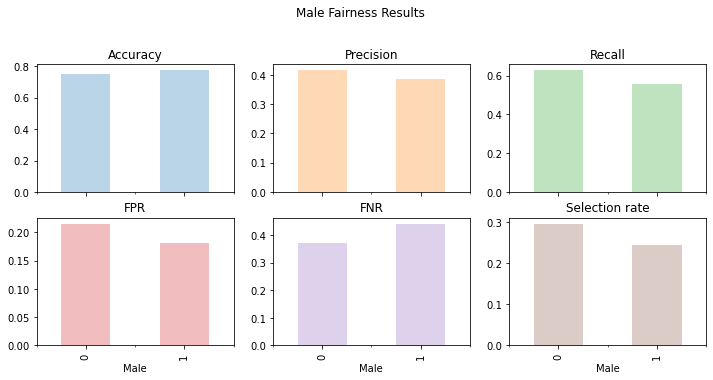

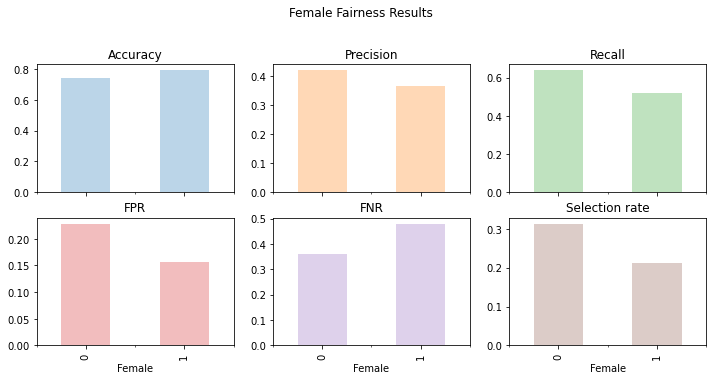

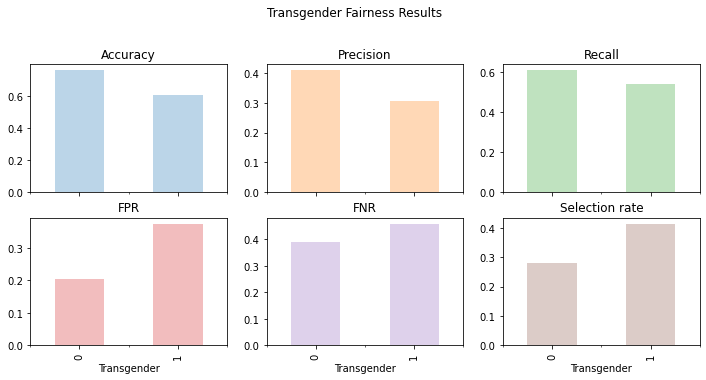

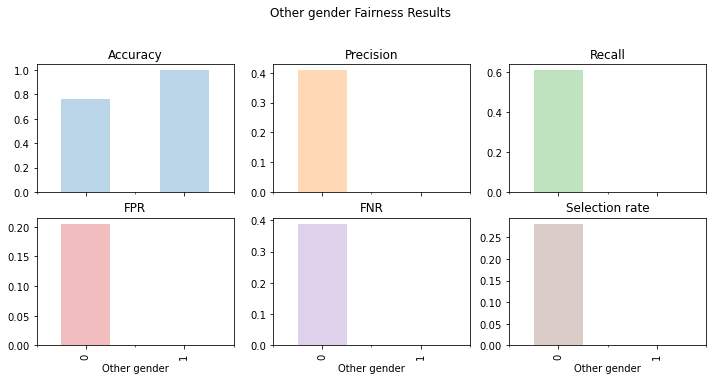

In [8]:
##############################################################################

# Dev Simple MLP evaluation
emb_mlp_eval = nlp_evaluation(emb_mlp, emb_dev)
emb_mlp_eval.publish()
emb_mlp_eval.fairness()

##############################################################################

___
### 4: Test Predictions

In [ ]:
##############################################################################

tst_predictions = True

##############################################################################

# Generates and saves predictions 
# @model: machine learning model
# @test_set: dataframe
# @returns: dataframe
def nlp_predictions(model, test_set):
    
    # Generate 
    predictions = pd.DataFrame(test_set.ids)
    predictions['Toxicity'] = pd.DataFrame(model.predict(test_set.comments))
    predictions.set_index('ID', inplace=True)

    if (tst_predictions):
        print("Predictions shape: ", predictions.shape)
        print("Head:")
        display(predictions.head(5))
        
    # Save
    filename = 'Predictions/' + model.descriptor + '_Test_Predictions'
    print(filename)
    predictions.to_csv(filename)
    
    return predictions

##############################################################################

In [ ]:
##############################################################################

# KNN emb_test
nlp_predictions(emb_knn3, emb_test)
print()

##############################################################################

In [ ]:
##############################################################################

# Bernoulli NB Test
nlp_predictions(emb_bnb, emb_test)
print()

##############################################################################

In [ ]:
##############################################################################

# Weighted Complement NB Test
nlp_predictions(emb_cnb, sc_emb_test)
print()

##############################################################################

In [ ]:
##############################################################################

# Logistic Regression Test
nlp_predictions(emb_lrm, emb_test)
print()

##############################################################################

In [ ]:
##############################################################################

# MLP Test
nlp_predictions(emb_mlp, emb_test)
print()

##############################################################################